# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import time
from datetime import timedelta
import cv2
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# TODO: fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Helper function for plotting images 
Function for plotting 9 images in a 3x3 grid 

In [3]:
img_size = 32
img_size_flat = img_size *img_size*3
img_shape = (img_size, img_size)
num_classes = 43

In [4]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    #create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        #plot image
        ax.imshow(images[i], cmap='binary')
        
        # show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        # remove ticks from the plot 
        ax.set_xticks([])
        ax.set_yticks([])
        

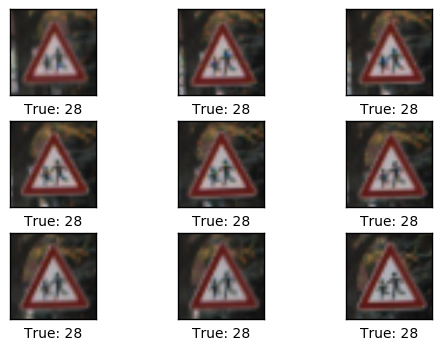

In [5]:
images = X_train[31000:31009]
cls_true = y_train[31000:31009]
plot_images(images = images, cls_true = cls_true)

class: 28


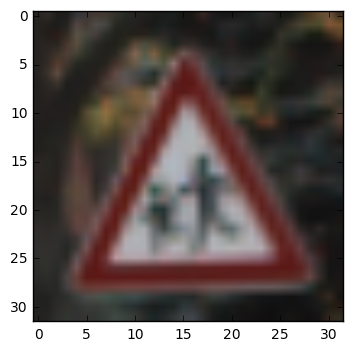

In [6]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
img_index = 31009
example_img = X_train[img_index]
plt.imshow(example_img)
print("class:" , y_train[img_index])

In [7]:
X_train[0].shape

(32, 32, 3)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

#### Preprocessing the dataset

Preprocessing the train, validation and test sets 
The folowing process uses the above function on the jittered data set (1.2 million images), the validation set (which I am making the same as the original X_train), and the test set (the original X_test).

The transform_image function The function tilts and warps the image within a random range. The function is called a number of times per image (right now my computer can only handle up to 40x per image -- to create a training set of 1.25 million images).

In [8]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
#     rows,cols,ch = img.shape 
    rows, cols = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

In [9]:
def pre_process_image(image):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (32,32),interpolation = cv2.INTER_CUBIC)
    
#     Min-Max scaling for greyscale image data
    Xmin = 0
    Xmax = 255
    a = 0.1
    b = 0.9
    
    image = a + ((image - Xmin) * (b-a)) / (Xmax-Xmin)

    return image

#### Preprocessing the images

The pre_process_image function takes the original image and converts it to grayscale, resizes it to 32x32, and then normalizes each grayscale pixel between 0.1 and 0.9. 

The flow of it was: 
1. convert to grayscale 
2. normalize
3. jitter to create a large training set
4. flatten


In [10]:
# preprocessing the original data - -converting to 1. grayscale and 2. normalizing

# the top two look similar, but I take the top one and jitter it later

image_GS_train = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))], dtype = np.float32)
image_GS_validation = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))], dtype = np.float32)
image_GS_test = np.array([pre_process_image(X_test[i]) for i in range(len(X_test))], dtype = np.float32)

print(len(image_GS_train))
print(len(image_GS_validation))
print(len(image_GS_test))
print((image_GS_train[0].shape))

39209
39209
12630
(32, 32)


In [11]:
# 3. creating 1.56 million images (around the best i could get my computer to do)

start_time = time.time()

jittered_images = []
jittered_labels = []

for i in range(len(image_GS_train)):
    for j in range(40):
        img = transform_image(image_GS_train[i],20,10,5)
        jittered_images.append(img)
        jittered_labels.append(y_train[i])

jittered_images = np.asarray(jittered_images)

end_time = time.time()
compute_time = end_time - start_time

print("compute time: " , str(timedelta(seconds = int(round(compute_time)))))
print("Length of the new jittered dataset: " , len(jittered_images))

compute time:  0:01:37
Length of the new jittered dataset:  1568360


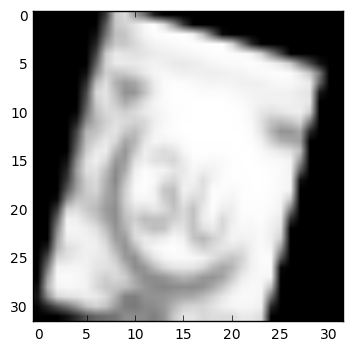

In [14]:
plt.imshow(jittered_images[10000], cmap='Greys_r')

In [25]:
# 4. Flattening the image data 
img_size_flat = 32*32

image_flat_train = jittered_images.reshape((-1,img_size_flat))
image_flat_validation = image_GS_validation.reshape((-1,img_size_flat))
image_flat_test  = image_GS_test.reshape((-1,img_size_flat))

print(len(image_flat_train))
print(len(image_flat_validation))
print(len(image_flat_test))
print((image_flat_train[0].shape))

1568360
39209
12630
(1024,)


#### One-Hot encoding the labels

In [27]:
y_train_encoded = np.eye(43)[jittered_labels]
y_validation_encoded = np.eye(43)[y_train]
y_test_encoded = np.eye(43)[y_test]

print(len(y_train_encoded))
print(len(y_validation_encoded))
print(len(y_test_encoded))

1568360
39209
12630


#### New Dataset facts 
The resultant datasets for the model are now: 


In [28]:
n_train = len(y_train_encoded)
n_validation = len(y_train)
n_test = len(y_test)
image_shape  = np.shape(X_train[1])
n_classes = len(np.unique(y_train))

img_size_flat = image_shape[0] * image_shape[1]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print("Image Size Flat =", img_size_flat)

Number of training examples = 1568360
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Image Size Flat = 1024


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I generated additional data from the original dataset, using the transform image above. Then I used that much larger data set as the training set. 

Then I set the original training set of 31k images as my validation set. And the original test set of 12k images remained the test set. 

The hope was that the additional data would give a better testing accuracy. 

## Architecture

### Some functions for creating layers: 

In [29]:
### Define your architecture here.
### Feel free to use as many code cells as needed.



In [30]:
# function for batching the data through the tensorflow model 

def random_batch():
    # Number of images in the training-set.
    num_images = len(image_flat_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    features_batch = image_flat_train[idx, :]
    labels_batch = y_train_encoded[idx, :]

    return features_batch, labels_batch

In [31]:
# functions for generating weights and biases

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


In [32]:
# function for creating a new convolutinal later, using pooling 

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [33]:
# function for flattening the layer

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [34]:
# function for creating a fuly connected layer

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer


### Placeholder variables and hyper parameters

In [125]:
img_size = 32
num_channels = 1
num_classes = 43
learning_rate = 0.2
batch_size = 100
keep_prob = 0.9

x = tf.placeholder(tf.float32, [None, img_size_flat])
y = tf.placeholder(tf.float32, [None, n_classes])

# sets up a place for the non one-hot classes to go
y_true_cls = tf.placeholder(tf.int64, [None])

# thhis is putting the images back into the 4 dimensional format for the convo layers
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])



In [126]:
# Convolutional Layer 1.
filter_size1 = 4         # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 4      # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128 

### Tensorflow Model

In [127]:
# convolutinal layer 1
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
    
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
    
# flatten Layer 
layer_flat, num_features = flatten_layer(layer_conv2)

# fully connected layer 1
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

# fully connected layer 2
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

layer_fc2 = tf.nn.dropout(layer_fc2, keep_prob)

y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension = 1)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(layer_fc2, y))

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)


correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [128]:
### Train your model here.
### Feel free to use as many code cells as needed.

def optimize(n_iterations):
    accuracy_list = []
    loss_list = []
    iteration_list = []
    
    for iteration in range(n_iterations):
        features_batch, labels_true_batch = random_batch()
        feed_dict_batch = {x: features_batch, y: labels_true_batch}
        sess.run(optimizer, feed_dict = feed_dict_batch)


In [132]:
start_time = time.time()

sess = tf.Session()
sess.run(tf.initialize_all_variables())

iter = 100

optimize(iter)

end_time = time.time()
compute_time = end_time - start_time

print("compute time: " , str(timedelta(seconds = int(round(compute_time)))))


compute time:  0:00:59


### Getting accuracy on the test set 

In [138]:
feed_dict_test = {x: image_flat_validation,
                  y: y_train,
                  y_true_cls:image_GS_validation}

acc = sess.run(accuracy,feed_dict=feed_dict_test)
print(acc)

ValueError: Cannot feed value of shape (39209,) for Tensor 'Placeholder_10:0', which has shape '(?, 43)'

In [134]:
# logging the output for future posterity

log_file = "log.txt"
special_note = "normalization and changed filters to 4x4px. uses an augmented dataset (40x), submission-model"
with open(log_file, "a") as myfile:
    myfile.write("\n"+str(iter)+","+str(learning_rate)+
                 ","+str(batch_size)+
                 ","+str(keep_prob)+
                 ","+ str(timedelta(seconds = int(round(compute_time))))+
                 ","+str(round(acc,2)) +
                 ","+special_note)


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The model was trained using the AdamOptimizer. The batch size I though twas the most efficient was around 100, and the number of iterations was 100k.  

The learning rate (learned by overfitting the tiny 9 image data set) was kept at 1e-3, and the "keep probability" -- the probablitly parameter for the dropout piece was maintained at 90%. 


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

The approach that worked best fror me was to first develop the model and practice over fitting a small subset (9 images) of the data. This process was quick and could generate a nice plot that represented the cost decreasing and the accuracy increasing. 

The benefit was that I could study the effects of some of the hyper parameters on the performance of the model, and adjust in a quickly iterative process. The parameters I delt with here were mainly the learning rate, regularization parameter and dropout percentage. 

Once I was satisfied with the basic architecture, I implemented the full dataset, and then the augmented data set. With this larger set of data the main pieces I worked with were the batch size and the number of iteratons. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [48]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

def plot_images(images, cls_true= None, cls_pred=None):
#     assert len(images) == len(cls_true) == 9
    
    #create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        #plot image
        ax.imshow(images[i].reshape(32,32),  cmap='Greys_r')
        
        # show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        # remove ticks from the plot 
        ax.set_xticks([])
        ax.set_yticks([])

In [49]:
import os, glob

new_signs= list()

path = "/home/deep_cat/traffic-signs-tensorflow/new_test_images"
test = os.path.join(path, '*.jpg')
print(test)

for infile in glob.glob(os.path.join(path, '*.jpg')):
    print(infile)
    img = cv2.imread(infile)
    arr1 = np.array(img)
    resize_img = cv2.resize(arr1, (32,32))
    new_signs.append(resize_img)
print(np.shape(new_signs))

/home/deep_cat/traffic-signs-tensorflow/new_test_images/*.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/459381023.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/459381275.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/traffic-signs-german.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/469763313.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/465921877.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/459381095.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/469763307.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/459381273.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/image.jpg
(9, 32, 32, 3)


In [50]:
def process_and_flatten(image_array):
    
    
    
    images_gray = np.array([pre_process_image(image_array[i]) for i in range(len(image_array))], dtype = np.float32)
    images_flat= images_gray.reshape((-1,img_size_flat))
    
#         Min-Max scaling for greyscale image data
    Xmin = 0
    Xmax = 255
    a = 0.1
    b = 0.9
    
    images_new = a + ((images_flat - Xmin) * (b-a)) / (Xmax-Xmin)
    return images_new


new_signs_flat = process_and_flatten(new_signs)

In [105]:
y_new_signs = [2,4,4,5,6,7,8,9,44]
len(y_new_signs)

9

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I chose 9 images from google image search and preprocessed them in the same manner as for the images above. Since the images began as a different sizes, the process for resizing and converting to grayscale warped them a bit. This may play into the  ability of the model to predict well, but the images are clear and should be decent data. 

The images are plotted below: 


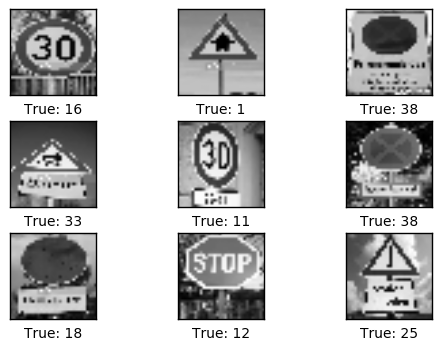

In [102]:
images = new_signs_flat[0:9]
cls_true = y_test[0:9]
plot_images(images = images, cls_true = cls_true, cls_pred = None)

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_

In [76]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

feed_dict = {x: new_signs_flat[0:9]}

top5 = tf.nn.top_k(y_pred, 5)

classification = sess.run(y_pred, feed_dict)

top5pred= sess.run(top5, feed_dict)
cls_pred = np.argmax(classification, axis=1)
print(cls_pred)
print(top5pred)

[12 13 12 12 12 12 12 12 12]
TopKV2(values=array([[ 0.06323786,  0.0531221 ,  0.05275793,  0.04772476,  0.03839582],
       [ 0.05669009,  0.05629725,  0.05092513,  0.04097494,  0.0404098 ],
       [ 0.05778762,  0.05738965,  0.05190978,  0.04120054,  0.04045828],
       [ 0.06670403,  0.05565094,  0.05034292,  0.04049785,  0.03994068],
       [ 0.06666178,  0.05600437,  0.05561727,  0.05030913,  0.04048015],
       [ 0.06516006,  0.0547371 ,  0.05437034,  0.04917922,  0.03956736],
       [ 0.06717794,  0.05605235,  0.05070598,  0.04079939,  0.04024409],
       [ 0.06736545,  0.05660015,  0.05620454,  0.05083957,  0.04091182],
       [ 0.06701972,  0.05630184,  0.05591782,  0.05058033,  0.04068644]], dtype=float32), indices=array([[12, 13,  4,  2,  1],
       [13,  4,  2,  1, 17],
       [13,  4,  2, 17, 35],
       [12,  4,  2,  1, 17],
       [12, 13,  4,  2,  1],
       [12, 13,  4,  2,  1],
       [12,  4,  2,  1, 17],
       [12, 13,  4,  2,  1],
       [12, 13,  4,  2,  1]], dtyp

In [80]:
# this seems to work also , but gets the indices
classification[0]
classification[0].argsort()[-5:][::-1]


array([12, 13,  4,  2,  1])

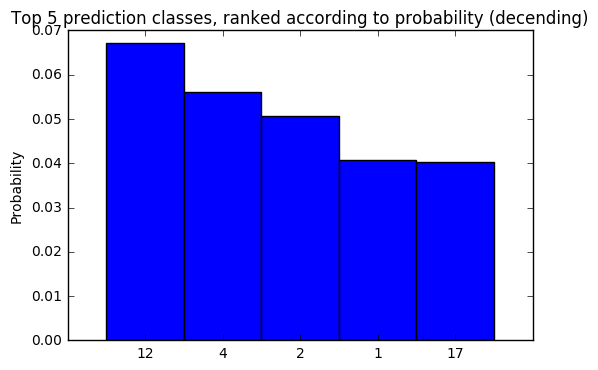

In [109]:
y = top5pred.values[6]
x = top5pred.indices[6]
y_pos = np.arange(len(top5pred.indices[0]))


width = 1/1
plt.bar(y_pos, y, width, color="blue", align = 'center')
plt.xticks(y_pos, x)
plt.ylabel('Probability')
plt.title('Top 5 prediction classes, ranked according to probability (decending)')

In [85]:
top5pred.indices

array([[12, 13,  4,  2,  1],
       [13,  4,  2,  1, 17],
       [13,  4,  2, 17, 35],
       [12,  4,  2,  1, 17],
       [12, 13,  4,  2,  1],
       [12, 13,  4,  2,  1],
       [12,  4,  2,  1, 17],
       [12, 13,  4,  2,  1],
       [12, 13,  4,  2,  1]], dtype=int32)

**Answer:**

In [66]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

top5 = tf.nn.top_k(y_pred, 5)
print(top5)

Tensor("TopKV2_7:0", shape=(?, 5), dtype=float32)


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.